1. Check that training vanilla RNNs on the CDM task is successfull using CtD
2. Generate neural trajectories (synthetic data) with the data-trained model
3. Fit another RNN and verify the relationships between the original and the fitted connectivity matrix J as is Fig 1b in Valente et al.

In [9]:
import random
import dotenv
import pathlib
import os
import torch
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

# import sys
# # to find the modules in ctd
# sys.path.append(HOME_DIR)

/scratch/network/ad2002/


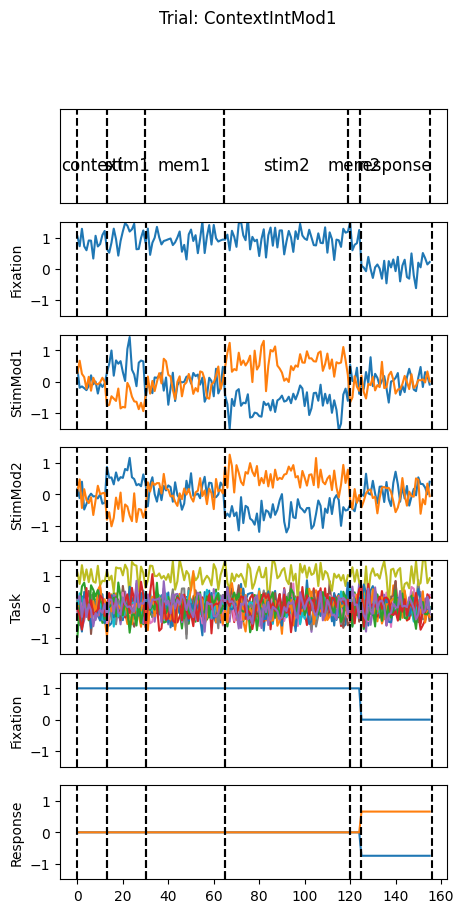

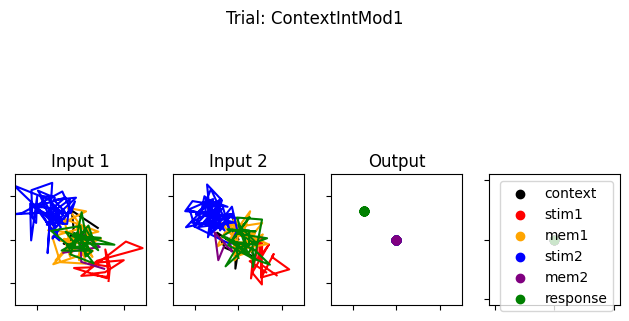

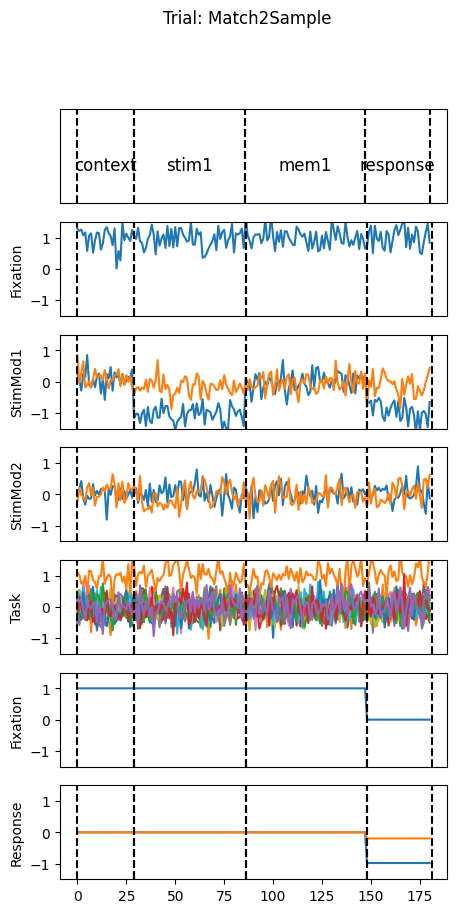

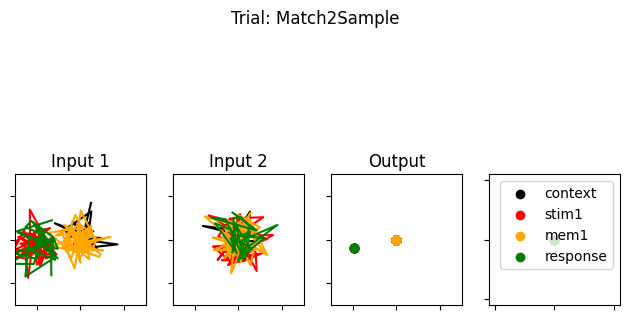

In [2]:
from ctd.task_modeling.task_env.multitask import MultiTaskWrapper

# CDM (context-dependent decision making) = ContextIntMod1/2 (also without context)
# DMS (delay match to sample) = Match2Sample (also non match)

multitask = MultiTaskWrapper(
    task_list = [
        "ContextIntMod1",
        "Match2Sample"
    ],
    noise = 0.3,
    num_targets = 32,
    bin_size=20,
    n_timesteps= 640,
    dynamic_noise = True,
)

multitask.plot_tasks()




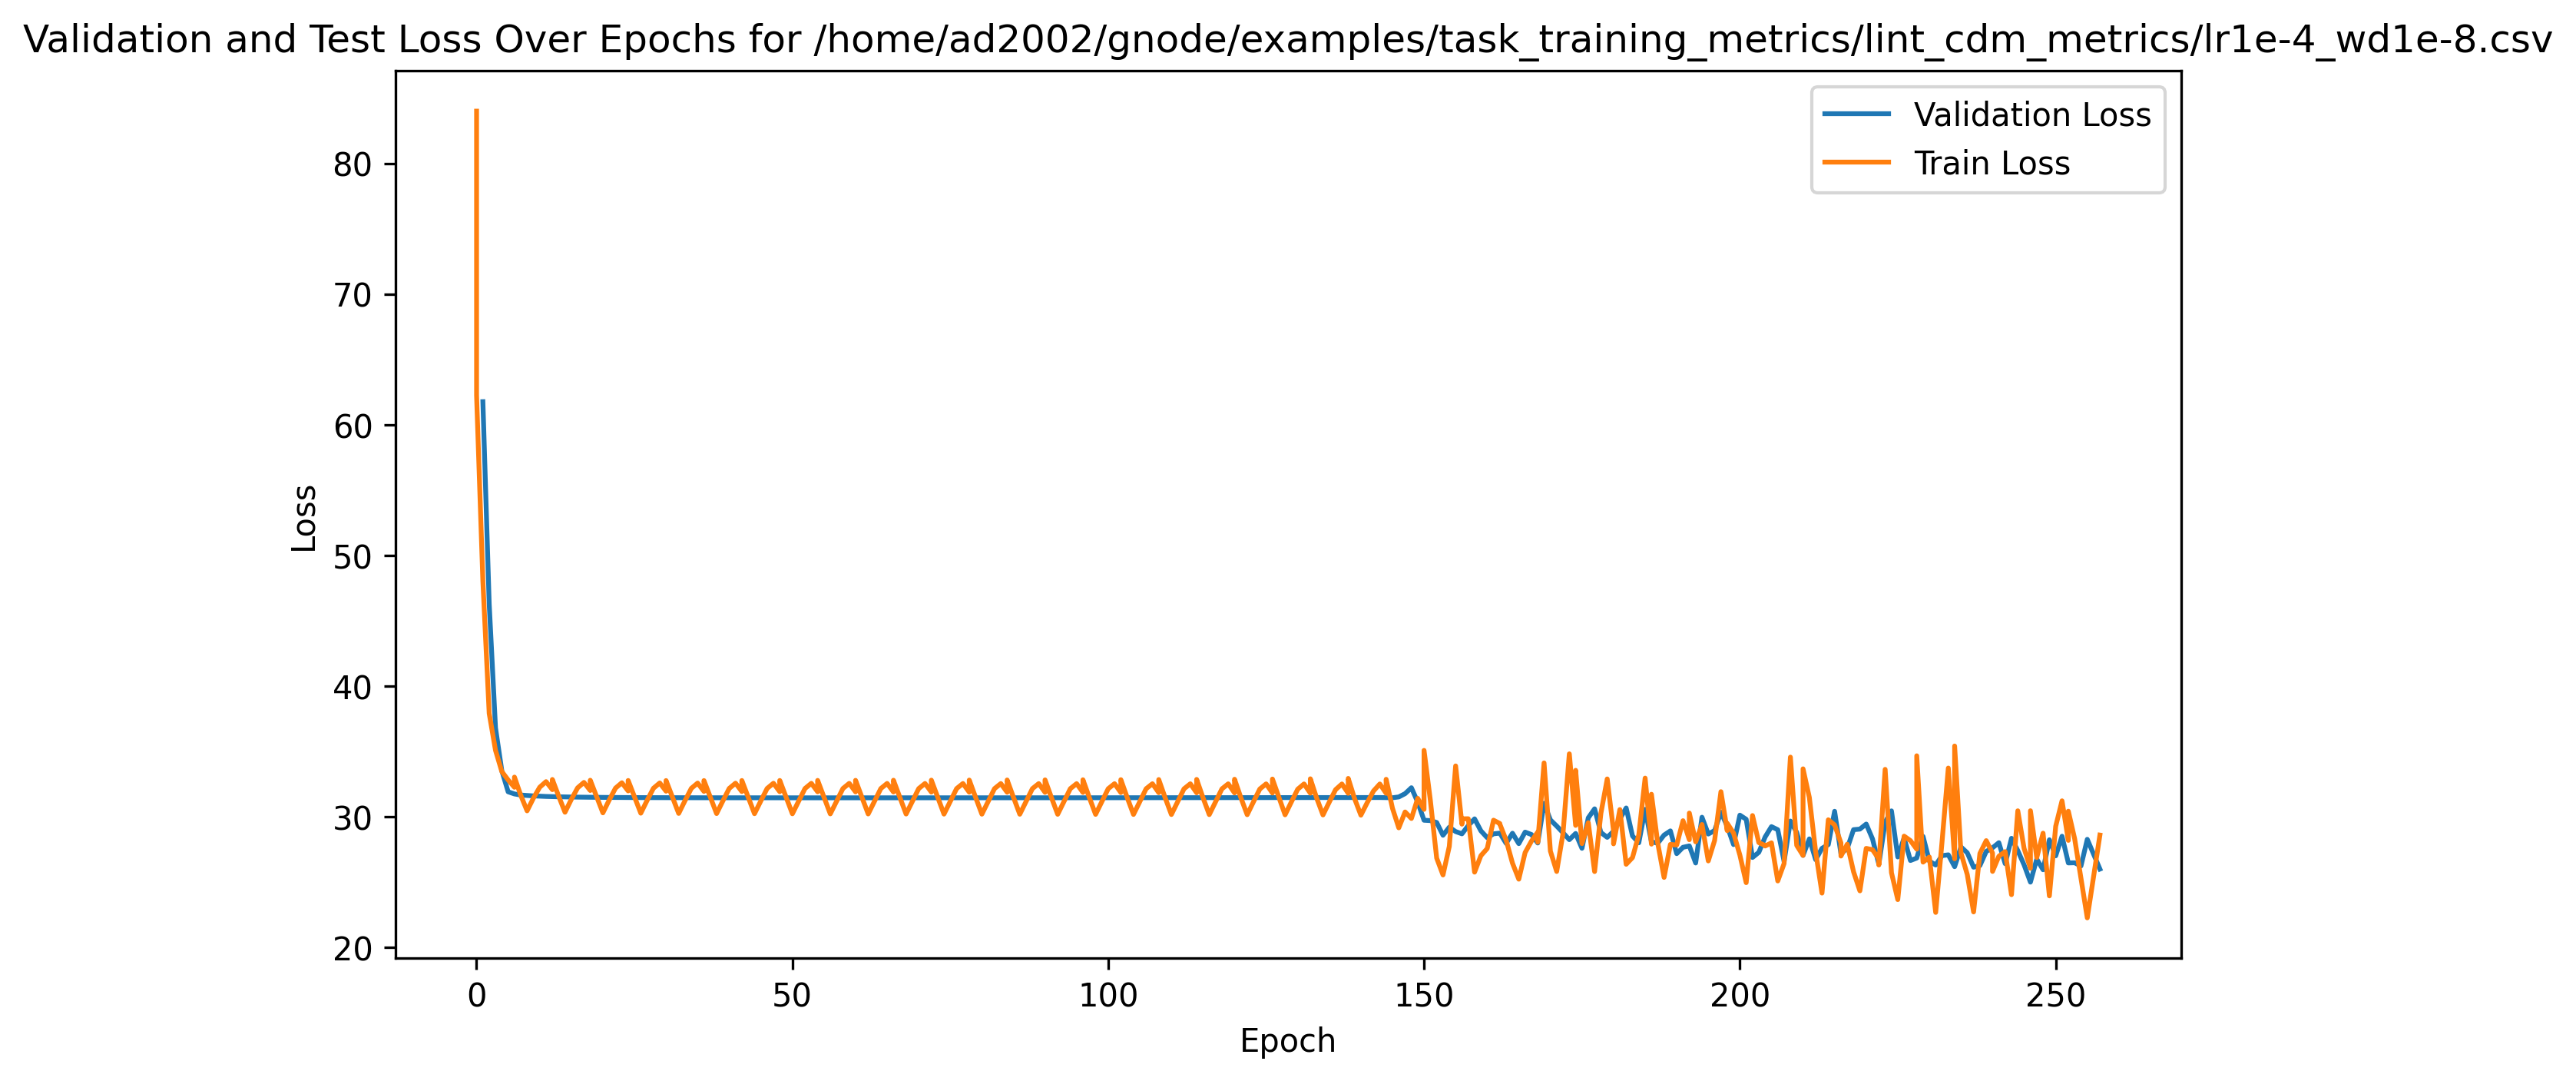

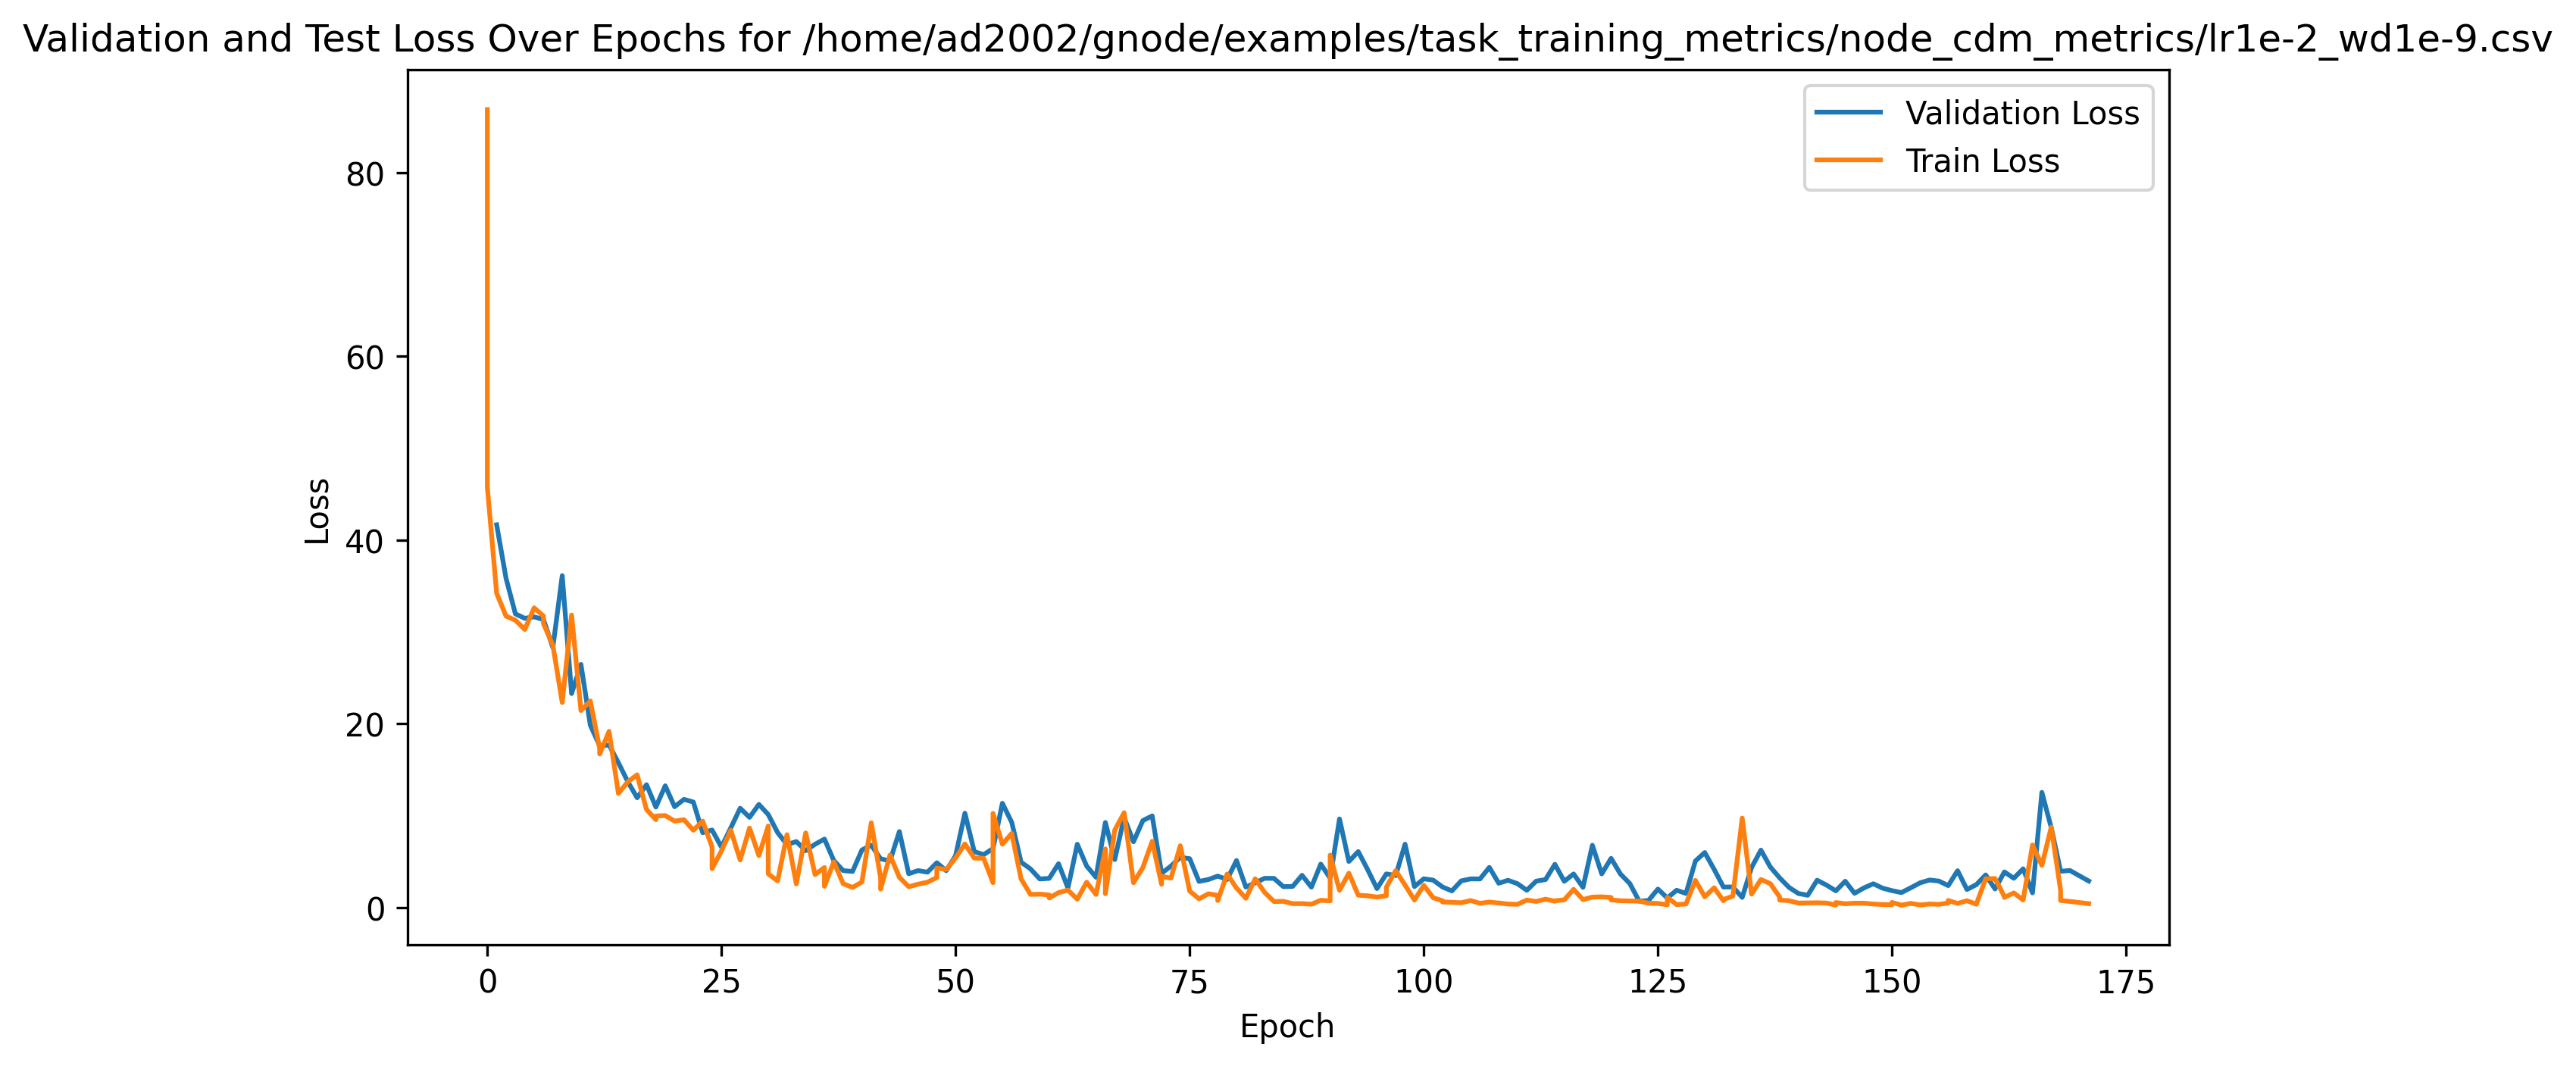

In [6]:
# too high learning rate in LintRNN explodes the MSE, node still prefers high lr and low wd

import ctd.comparison.metrics as metrics

# first best LINT fits
df_lint_cdm = metrics.plot_valid_train("/home/ad2002/gnode/examples/task_training_metrics/lint_cdm_metrics/", [300], access_df=True)
# and for NODE
df_node_cdm = metrics.plot_valid_train("/home/ad2002/gnode/examples/task_training_metrics/node_cdm_metrics/", [200], access_df=True)


In [10]:
from ctd.comparison.analysis.tt.tt import Analysis_TT

path = "/scratch/network/ad2002/content/trained_models/task-trained/20240608_node_CDM/latent_size=3 weight_decay=1e-09 learning_rate=0.01 max_epochs=300 log_every_n_steps=1 seed=0 batch_size=128 num_workers=1 n_samples=500 task_list=['ContextIntMod1'] task_list=['ContextIntMod1']/"
node_cdm_rank3 = Analysis_TT(run_name = "node_cdm_test", filepath = path)

# INPUTS: you can pass your own into the FPF, but it should not have the same shape as the internal inputs used
# in the actual FPF algorithm. Shape should be (n_trials, n_timesteps, n_input_channels)
# To return the latter and plot the velocity field with the same internal inputs, set return_points=True

# Ex: you can pass in the zero inputs below, and it will return the internal inputs that the FPF has transformed
# inputs to accounting for time and total trials. 
# OR you can set inputs to None, and will return random inputs that the FPF internally used
%matplotlib notebook
my_inputs = 1*torch.ones_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

fps_20, xstar_20, q_flag_20, color_20 = node_cdm_rank3.plot_fps(
    inputs= None,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-2,   # higher rate gives less but actually accurate values - NOTE the right learning rate for 
                            # this finder seems to be similar to the optimal for the model training. not a coincidence....
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True, 
    num_traj=2
)

AttributeError: 'LintRNN' object has no attribute 'cell'